## Machine Learning
After looking at the data in the previous steps, I decided to group the hurricane impacts per year into groups based on the number of hurricanes per year and the average category strength per year.

There is one main predictions that will be made:
1. The number of hurricanes severity for that year.
2. The average strength severity for that year.

**For lack of time I only did one prediction group (number of hurricanes for the year).  There is code written for two groups up until a point, then I notated where future work could be done.**

In [1]:
#load the necessary datasets and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

hurricanes_df = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 1/hurricanes_df.csv", 
                            index_col = 0, parse_dates=True)

wod_df_date = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 1/wod_df_date.csv", 
                          index_col = 0, parse_dates=True)

In [2]:
#have a look at the value counts for number of hurricanes per year occurrences
hurr_year = hurricanes_df.resample('A').count()
hurr_year = hurr_year[hurr_year.index.year <= 2012]
print('The value counts for the hurricanes per year data.')
print(hurr_year.name.value_counts().sort_index())
print()

#calculate average strength of hurricanes per year
cat_year = hurricanes_df.resample('A').mean().fillna(0)
cat_year = cat_year[cat_year.index.year <= 2012]
strengths = pd.Series([arr[0] for arr in cat_year.values], index = cat_year.index)
print('The value counts for the average strength per year data.')
print(strengths.value_counts().sort_index())

The value counts for the hurricanes per year data.
0     18
1     16
2     10
3      4
4      1
5      2
6      1
11     1
Name: name, dtype: int64

The value counts for the average strength per year data.
0.000000    18
1.000000    12
1.500000     2
1.666667     2
2.000000     6
2.166667     1
2.250000     1
2.500000     1
3.000000     7
3.666667     1
4.000000     2
dtype: int64


### After looking into the hurricane groupings, here are the categories for the groupings.


I chose to do groups intstead of linear regression techniques because I have strong suspicions that the model will always perform poorly if trying to predict the exact number of hurricanes per year or exact average strength per year.  Groups will allow for classification which I believe the model will have more success performing.  The impact is still similar in that we can still obtain quality information about the severity of the upcoming hurricane season.

Moreover, the scoring criterion for the models will be the classification report which includes precision, recall, and f1 scores for each class and an average for the scores.  Emphasis will be put on the f1_score as this score is best indicative in this case for a better model as I don't want too many false positives, and I also don't want too many false negatives.


1. Hurricanes per year:
    * No Impacts (0)
        * 0 hurricanes
    * Moderate (1)
        * 1-2 hurricanes
    * Severe (2)
        * 3+ hurricanes
2. Average strength per year:
    * Mild (0)
        * 0-1.5 average category ranking
    * Moderate (1)
        * 1.5-3 average category ranking
    * Severe (2)
        * 3-5 average category ranking
        
        
### Feature Engineering and Model Selection
1. Features
    * Since temperature was the only statistically significant trend, let's try just temperature as a feature first.
    * Try adding in the rest of the wod features into the model next.
        * The features will be averages for the time before the hurricane season (January 1st to May 31st) for that year.
    * Try adding in previous years ocean data as features.
        * The features will be averages for the time before the hurricane season (January 1st to May 31st) for the previous year.
    * Try adding in previous years number of hurricanes and average strength as features.
2. Models
    * Logistic Regression
    * SVM Classification
    * kNN
    
### Getting the features ready
#### Ocean data only
* We need to first get the world ocean database to be in the form of one observation per row with columns being the different features.

In [3]:
#fix up the wod df to be the feature set.
wod_yr = wod_df_date.loc[wod_df_date.index.month < 6].resample('A').mean()
X = np.array(wod_yr.reset_index(drop=True))

#create group labels for each case for number of hurricanes
y_hurr = np.empty(len(wod_yr.index))
for i, index in enumerate(wod_yr.index):
    if hurr_year.name[index] == 0:
        y_hurr[i] = int(0)
    elif (hurr_year.name[index]>=1) & (hurr_year.name[index]<=2):
        y_hurr[i] = int(1)
    elif hurr_year.name[index]>=3:
        y_hurr[i] = int(2)
        
#create group labels for each case for average strength of hurricanes
y_strength = np.empty(len(wod_yr.index))
for i, index in enumerate(wod_yr.index):
    if strengths[index] <= 1.5:
        y_strength[i] = 0
    elif (strengths[index]>1.5) & (strengths[index]<=3):
        y_strength[i] = 1
    else:
        y_strength[i] = 2

### 1. Logistic Regression
* ### A. Number of Hurricanes with just Temperature

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


def clf_mod_test(pipeline, data, target, params, split_test_size=.3, rand_iters=10, cv_folds=3, class_labels=[]):
    """Takes a pipeline, data, targets, CV search params, test_size, 
    number of iters and number of folds for RandomizedSearchCV, and the labels of classes.
    
    Returns a tuned and fitted model and f1 weighted score and prints a classification report and f1 score."""
    
    #split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = split_test_size, random_state=42)

    #run grid search on pipeline
    gm_cv = RandomizedSearchCV(pipeline, param_distributions = params, 
                               cv=cv_folds, n_iter=rand_iters, random_state=42)
    
    gm_cv.fit(X_train, y_train)
    C = gm_cv.best_params_['logistic_regression__C']
    print('The best C value is {}, with an accuracy of {}.'.format(gm_cv.best_params_['logistic_regression__C'], gm_cv.best_score_))
    print()

    #test model on test dataset and get classification report.
    y_pred = gm_cv.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=class_labels))
    print()
    
    #get f1 score for model comparison
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('The f1 score is : {}'.format(f1))
    
    return gm_cv, f1, C

#set up pipeline
steps = [('scaler', StandardScaler())
        ,('logistic_regression', LogisticRegression())]

pipeline_lr = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_lr = {'logistic_regression__C':np.logspace(-5,5,100000)}
hurr_labels=['no impact', 'moderate', 'severe']




lr_hurr_temp, f1_hurr_temp, C_hurr_temp = clf_mod_test(pipeline = pipeline_lr, data=X[:,4].reshape(-1,1), 
                                                       target=y_hurr, params=params_lr, 
                                                       rand_iters=10000, class_labels=hurr_labels, 
                                                       split_test_size=.3, cv_folds=3)
coeffs = lr_hurr_temp.best_estimator_.named_steps['logistic_regression'].coef_
print('The model coefficients are no impact:{}, moderate:{}, severe:{}.'.format(coeffs[0],coeffs[1],coeffs[2]))
print()
   

The best C value is 373.4012107035736, with an accuracy of 0.4864864864864865.

             precision    recall  f1-score   support

  no impact       1.00      0.25      0.40         4
   moderate       0.67      1.00      0.80        10
     severe       0.00      0.00      0.00         2

avg / total       0.67      0.69      0.60        16


The f1 score is : 0.6
The model coefficients are no impact:[ 0.32060372], moderate:[ 0.11399353], severe:[-0.67968092].



C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* ### B. Now use all the wod data as features

In [5]:
lr_hurr_wod, f1_hurr_wod, C_hurr_wod = clf_mod_test(pipeline = pipeline_lr, data=X, target=y_hurr, 
                                                              params=params_lr,rand_iters=10000, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
coeffs = lr_hurr_wod.best_estimator_.named_steps['logistic_regression'].coef_
print('The model coefficients are no impact:{}, moderate:{}, severe:{}.'.format(coeffs[0],coeffs[1],coeffs[2]))
    
print()

The best C value is 0.0009692144138389965, with an accuracy of 0.6216216216216216.

             precision    recall  f1-score   support

  no impact       1.00      0.25      0.40         4
   moderate       0.58      0.70      0.64        10
     severe       0.00      0.00      0.00         2

avg / total       0.61      0.50      0.50        16


The f1 score is : 0.4977272727272728
The model coefficients are no impact:[ 0.00347225 -0.00244249  0.00154245 -0.0032014   0.00258036], moderate:[-0.00136414 -0.0027272   0.00433682 -0.00240796  0.00095251], severe:[-0.00210819  0.0051698  -0.00587929  0.00560941 -0.00353292].



* After adding in all the wod features into the model, the model performed worse.

* ### C. Add in previous year's wod data as features.

In [6]:
#add in the feature to the data and drop first row as it won't have a last year's data field
wod_last_yr = wod_yr.copy()
wod_last_yr.index = wod_last_yr.index.year
for year in range(1961,2013):
    for feature in wod_yr.columns.values:
        wod_last_yr.loc[year,str(feature)+'_last']=wod_last_yr.loc[year-1,feature]

X_last = np.array(wod_last_yr.iloc[1:,:].reset_index(drop=True))

#run logreg model

lr_hurr_last, f1_hurr_last, C_hurr_last = clf_mod_test(pipeline = pipeline_lr, data=X_last, target=y_hurr[1:], 
                                                              params=params_lr,rand_iters=10000, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
coeffs = lr_hurr_last.best_estimator_.named_steps['logistic_regression'].coef_
print('The model coefficients are no impact:{}, moderate:{}, severe:{}.'.format(coeffs[0],coeffs[1],coeffs[2]))
    
print()

The best C value is 0.0009692144138389965, with an accuracy of 0.4722222222222222.

             precision    recall  f1-score   support

  no impact       0.33      0.25      0.29         4
   moderate       0.46      0.86      0.60         7
     severe       0.00      0.00      0.00         5

avg / total       0.29      0.44      0.33        16


The f1 score is : 0.33392857142857146
The model coefficients are no impact:[  4.75926532e-04  -2.60364805e-03   2.97027246e-03  -4.12127607e-03
   6.32142249e-03  -1.02988774e-07   3.39883241e-03  -1.93292285e-03
  -2.04532070e-03   3.50968759e-03], moderate:[ 0.00187972  0.00247981  0.00062146  0.00241092 -0.0033971  -0.00438146
 -0.00286208  0.00361071  0.0022551  -0.00195502], severe:[-0.00235578  0.00012372 -0.00359176  0.00171025 -0.00292425  0.00438162
 -0.00053667 -0.0016779  -0.00020977 -0.0015546 ].



C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* After adding in last year's wod_features it seems that the performance is worse.

* ### D. Add in the previous years number of hurricanes and average strength as features.

In [7]:
#add in the feature to the data and drop first row as it won't have a last year's data field
wod_last_yr_hurr = wod_last_yr.copy()
hurr_yr = hurr_year.copy()
hurr_yr.index = hurr_yr.index.year
hurricanes = hurr_yr.name
strengths.index = strengths.index.year

for year in range(1961,2013):
    wod_last_yr_hurr.loc[year,'last_yr_hurr']=hurricanes[year-1]
    wod_last_yr_hurr.loc[year,'last_yr_str']=strengths[year-1]

X_last_hurr = np.array(wod_last_yr_hurr.iloc[1:,:].reset_index(drop=True))

#run logreg model
lr_hurr_last_hurr, f1_hurr_last_hurr, C_hurr_last_hurr = clf_mod_test(pipeline = pipeline_lr, data=X_last_hurr, 
                                                                                target=y_hurr[1:], 
                                                              params=params_lr,rand_iters=10000, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
coeffs = lr_hurr_last_hurr.best_estimator_.named_steps['logistic_regression'].coef_
print('The model coefficients are no impact:{}, moderate:{}, severe:{}.'.format(coeffs[0],coeffs[1],coeffs[2]))
    
print()

The best C value is 2.7381319606058225, with an accuracy of 0.3888888888888889.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         4
   moderate       0.50      1.00      0.67         7
     severe       1.00      0.40      0.57         5

avg / total       0.53      0.56      0.47        16


The f1 score is : 0.47023809523809523
The model coefficients are no impact:[ 0.27122495 -0.18562546 -0.05209556 -0.96881214  0.28231419 -0.13042503
  0.51275298 -0.79375581 -0.27810071  0.72216618  0.12899747  0.36511647], moderate:[ 0.38577182  0.21214017  0.41410588  0.3803529  -0.06595155 -0.7265404
 -0.44780912  0.51033103  0.49164684 -0.89550753 -0.43187262 -0.24181826], severe:[-1.38002593  0.04824471 -0.6779403   0.65155592 -0.34236895  1.04690628
 -0.04195795  0.26024669 -0.44873431  0.36207536  0.4025181  -0.43345288].



C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The f1 scores for the logistic regression models.


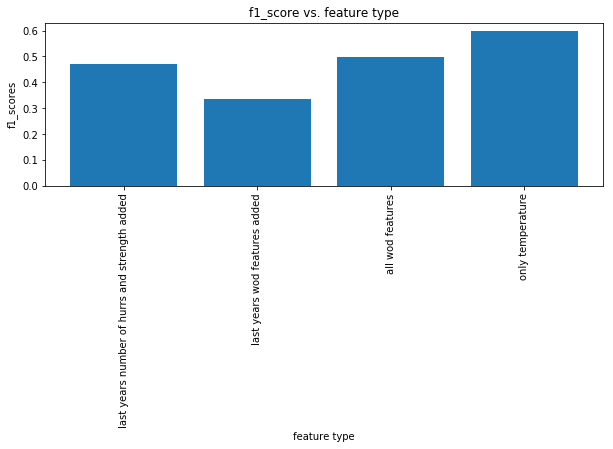

In [19]:
print('The f1 scores for the logistic regression models.')
plt.figure(figsize = (10,3))
plt.bar(x=range(4), height=[f1_hurr_last_hurr,f1_hurr_last, f1_hurr_wod, f1_hurr_temp], 
            tick_label=['last years number of hurrs and strength added','last years wod features added','all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')
plt.xticks(rotation=90)

plt.show()

* After adding in last year's strength and number of hurricanes, the model performed better but still worse than the all wod features and temperature only models.

* ### Summary: For logistic regression for the features that I have I would choose to run with temperature as the only feature as the performance was the best.
    * C decreased as the number of features increased until the last model where C increased.  This suggests mostly that as the complexity of the model increased, regularization was increased to balance out bias and variance to prevent over fitting.
    * More research into features need to be done in order to create a better model and/or more data is needed.
    
### 2. SVM Classification

* ### A. Temperature only

In [26]:
from sklearn.svm import SVC

def svc_mod_test(pipeline, data, target, params, split_test_size=.3, rand_iters=10, cv_folds=3, class_labels=[]):
    """Takes a pipeline, data, targets, CV search params, test_size, 
    number of iters and number of folds for RandomizedSearchCV, and the labels of classes.
    
    Returns a tuned and fitted model and f1 weighted score and prints a classification report and f1 score."""
    
    #split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = split_test_size, random_state=42)

    #run grid search on pipeline
    gm_cv = RandomizedSearchCV(pipeline, param_distributions = params, cv=cv_folds, n_iter=rand_iters, random_state=42)
    gm_cv.fit(X_train, y_train)
    C = gm_cv.best_params_['svm__C']
    gamma = gm_cv.best_params_['svm__gamma']
    print('The best param values are {}, with an accuracy of {}.'.format(gm_cv.best_params_, gm_cv.best_score_))
    print()

    #test model on test dataset and get classification report.
    y_pred = gm_cv.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=class_labels))
    print()
    
    #get f1 score for model comparison
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('The f1 score is : {}'.format(f1))
    
    return gm_cv, f1, C, gamma

#set up pipeline
steps = [('scaler', StandardScaler())
        ,('svm', SVC())]

pipeline_svc = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_svc = {'svm__C':np.logspace(-5, 5, 40000),
              'svm__gamma':np.logspace(-5, 5,40000)}
hurr_labels=['no impact', 'moderate', 'severe']



#run svm classification
svc_hurr_temp, f1_hurr_temp, C_hurr_temp, gamma_hurr_temp = svc_mod_test(pipeline = pipeline_svc, data=X[:,4].reshape(-1,1), 
                                                       target=y_hurr, params=params_svc, 
                                                       rand_iters=10000, class_labels=hurr_labels, 
                                                       split_test_size=.3, cv_folds=3)
    
print('support vectors coeffs: {}'.format(svc_hurr_temp.best_estimator_.named_steps['svm'].dual_coef_))
print()
print('support vecotrs: {}'.format(svc_hurr_temp.best_estimator_.named_steps['svm'].support_vectors_))
print()

The best param values are {'svm__gamma': 0.038048672451264247, 'svm__C': 22425.067984813617}, with an accuracy of 0.5675675675675675.

             precision    recall  f1-score   support

  no impact       0.50      0.25      0.33         4
   moderate       0.73      0.80      0.76        10
     severe       0.67      1.00      0.80         2

avg / total       0.66      0.69      0.66        16


The f1 score is : 0.6595238095238095
support vectors coeffs: [[ 22425.06798481  22425.06798481  16585.40955914  22425.06798481
   14534.70325226      0.          22425.06798481  22425.06798481
   22425.06798481  22425.06798481  22425.06798481  22425.06798481      0.
   13300.24327417 -22425.06798481 -22425.06798481 -22425.06798481
   -7129.16020255 -22425.06798481 -22425.06798481 -22425.06798481
  -22425.06798481 -22425.06798481 -22425.06798481 -22425.06798481
  -14866.12789821 -22425.06798481 -22425.06798481 -22425.06798481
  -15423.33544566 -22425.06798481 -22425.06798481]
 [     0.     

* ### B. All wod features

In [27]:
svc_hurr_wod, f1_hurr_wod, C_hurr_wod, gamma_hurr_wod = svc_mod_test(pipeline = pipeline_svc, data=X, target=y_hurr, 
                                                              params=params_svc,rand_iters=10000, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
print('support vectors coeffs: {}'.format(svc_hurr_wod.best_estimator_.named_steps['svm'].dual_coef_))
print()
print('support vecotrs: {}'.format(svc_hurr_wod.best_estimator_.named_steps['svm'].support_vectors_))
print()

The best param values are {'svm__gamma': 0.007741448349644805, 'svm__C': 88.445077504229744}, with an accuracy of 0.5675675675675675.

             precision    recall  f1-score   support

  no impact       0.67      0.50      0.57         4
   moderate       0.67      0.80      0.73        10
     severe       0.00      0.00      0.00         2

avg / total       0.58      0.62      0.60        16


The f1 score is : 0.5974025974025974
support vectors coeffs: [[ 88.4450775   88.4450775   88.4450775   88.4450775    7.56389106
   88.4450775   88.4450775   88.4450775   88.4450775   88.4450775
   88.4450775   88.4450775   15.87939937  88.4450775  -88.4450775
  -61.20991853  -0.         -88.4450775  -88.4450775  -88.4450775
  -88.4450775  -88.4450775  -88.4450775  -88.4450775  -88.4450775
  -88.4450775  -30.223809   -20.4546404  -88.4450775  -88.4450775
  -88.4450775  -17.5465887  -88.4450775  -88.4450775 ]
 [  0.           0.          42.61209405  88.4450775   61.74622836   0.
   88.44507

* After adding in all the wod features into the model, the model performed slightly worse
* Moreover, the performance is slightly better than the corresponding feature set logistic regression models.

* ### C. Add in previous year's wod data as features.

In [28]:
svc_hurr_last, f1_hurr_last, C_hurr_last, gamma_hurr_last = svc_mod_test(pipeline = pipeline_svc, data=X_last, target=y_hurr[1:], 
                                                              params=params_svc,rand_iters=10000, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
print('support vectors coeffs: {}'.format(svc_hurr_last.best_estimator_.named_steps['svm'].dual_coef_))
print()
print('support vecotrs: {}'.format(svc_hurr_last.best_estimator_.named_steps['svm'].support_vectors_))
print()

The best param values are {'svm__gamma': 0.00041907384550764502, 'svm__C': 243.04385335046564}, with an accuracy of 0.5555555555555556.

             precision    recall  f1-score   support

  no impact       0.50      0.25      0.33         4
   moderate       0.54      1.00      0.70         7
     severe       1.00      0.20      0.33         5

avg / total       0.67      0.56      0.49        16


The f1 score is : 0.49375
support vectors coeffs: [[ 243.04385335  243.04385335  243.04385335  243.04385335  243.04385335
   209.72370787  243.04385335  243.04385335  243.04385335  243.04385335
   243.04385335   21.47548891  233.24655081  -14.70656076 -243.04385335
  -243.04385335 -243.04385335 -243.04385335  -17.68242067 -243.04385335
  -243.04385335  -43.47365033   -0.         -243.04385335 -243.04385335
  -145.53926248 -243.04385335 -243.04385335 -243.04385335 -243.04385335
  -243.04385335 -148.96447398 -127.67376866]
 [   0.            0.           29.90087262    0.            0.    

* After adding in last year's wod_features it seems that the performance is slightly worse than with all the wod features.
* Also, the performance to the logistic regression model is still better.

* ### D. Add in the previous years number of hurricanes and average strength as features.

In [30]:
svc_hurr_last_hurr, f1_hurr_last_hurr, C_hurr_last_hurr, gamma_hurr_last_hurr = svc_mod_test(pipeline = pipeline_svc, data=X_last_hurr, target=y_hurr[1:], 
                                                              params=params_svc,rand_iters=10000, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
print('support vectors coeffs: {}'.format(svc_hurr_last_hurr.best_estimator_.named_steps['svm'].dual_coef_))
print()
print('support vecotrs: {}'.format(svc_hurr_last_hurr.best_estimator_.named_steps['svm'].support_vectors_))
print()

The best param values are {'svm__gamma': 3.9606361228676616e-05, 'svm__C': 203.32121887967944}, with an accuracy of 0.5277777777777778.

             precision    recall  f1-score   support

  no impact       0.00      0.00      0.00         4
   moderate       0.44      1.00      0.61         7
     severe       0.00      0.00      0.00         5

avg / total       0.19      0.44      0.27        16


The f1 score is : 0.266304347826087
support vectors coeffs: [[ 203.32121888  203.32121888  203.32121888  203.32121888  203.32121888
   203.32121888  203.32121888  203.32121888  203.32121888  203.32121888
   203.32121888  203.32121888  203.32121888  203.32121888  -51.80790533
    -0.         -203.32121888 -203.32121888 -203.32121888 -203.32121888
   -28.96684654 -203.32121888 -146.93421283   -0.         -203.32121888
  -203.32121888 -203.32121888 -182.78305421 -199.47163773 -203.32121888
  -203.32121888 -203.32121888 -203.32121888 -203.32121888 -203.32121888
  -203.32121888]
 [   2.244188

C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The f1 scores for the svm classification models.


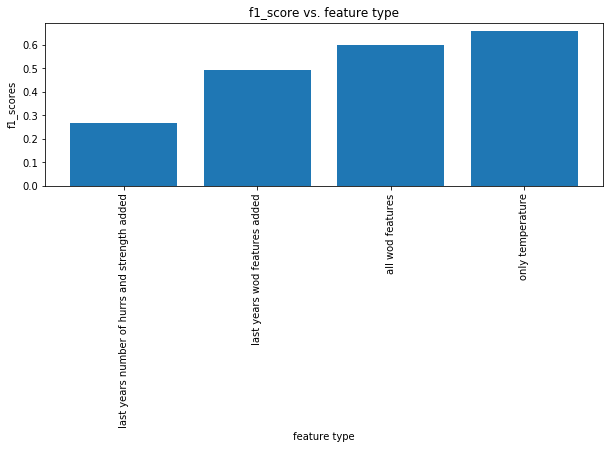

In [31]:
print('The f1 scores for the svm classification models.')
plt.figure(figsize = (10,3))
plt.bar(x=range(4), height=[f1_hurr_last_hurr,f1_hurr_last, f1_hurr_wod, f1_hurr_temp], 
            tick_label=['last years number of hurrs and strength added','last years wod features added','all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')
plt.xticks(rotation=90)

plt.show()

* After adding in last year's strength and number of hurricanes, the model performs worse.

* ### Summary: For svm classification for the features that I have I would choose to run with temperature as the only feature.
    * More research into features need to be done in order to create a better model and/or more data is needed.
    * Also the model performed on average better than logistic regression.
    * gamma steadily decreased by an order of magnitude at a time suggesting that as more features were added the model was tuning to add in more bias to counteract overfitting.

### 3. k Nearest Neighbors

* ### A. Temperature only

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def knn_mod_test(pipeline, data, target, params, split_test_size=.3, cv_folds=3, class_labels=[]):
    """Takes a pipeline, data, targets, CV search params, test_size, 
    number of folds for GridSearchCV, and the labels of classes.
    
    Returns a tuned and fitted model and f1 weighted score and prints a classification report and f1 score."""
    
    #split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = split_test_size, random_state=42)

    #run grid search on pipeline
    gm_cv = GridSearchCV(pipeline, param_grid = params, cv=cv_folds)
    gm_cv.fit(X_train, y_train)
    k = gm_cv.best_params_['knn__n_neighbors']
    print('The best param values are {}, with an accuracy of {}.'.format(gm_cv.best_params_, gm_cv.best_score_))
    print()

    #test model on test dataset and get classification report.
    y_pred = gm_cv.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=class_labels))
    print()
    
    #get f1 score for model comparison
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('The f1 score is : {}'.format(f1))
    
    return gm_cv, f1, k

#set up pipeline
steps = [('scaler', StandardScaler())
        ,('knn', KNeighborsClassifier())]

pipeline_knn = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_knn = {'knn__n_neighbors':np.arange(1, 20, 1)}
hurr_labels=['no impact', 'moderate', 'severe']


#run kNN
knn_hurr_temp, f1_hurr_temp, k_hurr_temp = knn_mod_test(pipeline = pipeline_knn, data=X[:,4].reshape(-1,1), 
                                                       target=y_hurr, params=params_knn, class_labels=hurr_labels, 
                                                       split_test_size=.3, cv_folds=3)
    

The best param values are {'knn__n_neighbors': 9}, with an accuracy of 0.4594594594594595.

             precision    recall  f1-score   support

  no impact       1.00      0.25      0.40         4
   moderate       0.75      0.90      0.82        10
     severe       0.67      1.00      0.80         2

avg / total       0.80      0.75      0.71        16


The f1 score is : 0.7113636363636363


* ### B. All wod features

In [33]:
knn_hurr_wod, f1_hurr_wod, k_hurr_wod = knn_mod_test(pipeline = pipeline_knn, data=X, target=y_hurr, 
                                                              params=params_knn, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    
    

The best param values are {'knn__n_neighbors': 11}, with an accuracy of 0.5405405405405406.

             precision    recall  f1-score   support

  no impact       1.00      0.25      0.40         4
   moderate       0.67      1.00      0.80        10
     severe       0.00      0.00      0.00         2

avg / total       0.67      0.69      0.60        16


The f1 score is : 0.6


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* After adding in all the wod features into the model, the model performed a little worse.
* Moreover, the performance is better than the logistic regression and svm classification performance.

* ### C. Add in previous year's wod data as features.

In [34]:
knn_hurr_last, f1_hurr_last, k_hurr_last = knn_mod_test(pipeline = pipeline_knn, data=X_last, target=y_hurr[1:], 
                                                              params=params_knn, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    


The best param values are {'knn__n_neighbors': 7}, with an accuracy of 0.6111111111111112.

             precision    recall  f1-score   support

  no impact       0.33      0.25      0.29         4
   moderate       0.54      1.00      0.70         7
     severe       0.00      0.00      0.00         5

avg / total       0.32      0.50      0.38        16


The f1 score is : 0.3776785714285715


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* After adding in last year's wod features it seems that the performance was worse again.
* Also, the performance was slightly better when compared with logistic regression and slightly worse when compared to the svm classification model.

* ### D. Add in the previous years number of hurricanes and average strength as features.

In [36]:
knn_hurr_last_hurr, f1_hurr_last_hurr, k_hurr_last_hurr = knn_mod_test(pipeline = pipeline_knn, data=X_last_hurr, target=y_hurr[1:], 
                                                              params=params_knn, 
                                                              class_labels=hurr_labels, split_test_size=.3, cv_folds=3)
    


The best param values are {'knn__n_neighbors': 13}, with an accuracy of 0.5555555555555556.

             precision    recall  f1-score   support

  no impact       0.50      0.25      0.33         4
   moderate       0.50      1.00      0.67         7
     severe       0.00      0.00      0.00         5

avg / total       0.34      0.50      0.37        16


The f1 score is : 0.37499999999999994


C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sethh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The f1 scores for the knn classification models.


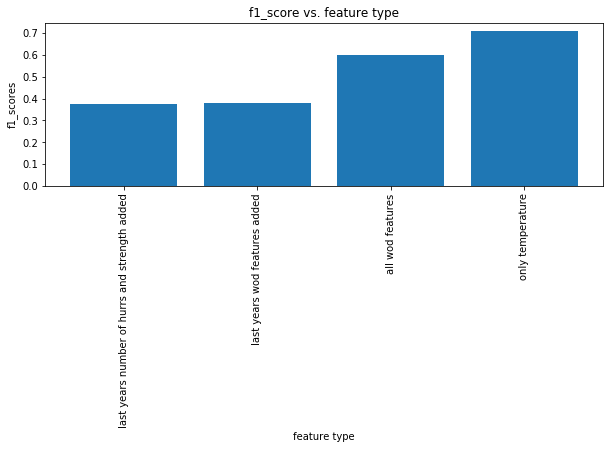

In [37]:
print('The f1 scores for the knn classification models.')
plt.figure(figsize = (10,3))
plt.bar(x=range(4), height=[f1_hurr_last_hurr,f1_hurr_last, f1_hurr_wod, f1_hurr_temp], 
            tick_label=['last years number of hurrs and strength added','last years wod features added','all wod features','only temperature'])
plt.title('f1_score vs. feature type')
plt.ylabel('f1_scores')
plt.xlabel('feature type')
plt.xticks(rotation=90)

plt.show()

* After adding in last year's strength and number of hurricanes, the model still performs on average the same.

* ### Summary: For knn classification for the features that I have I would choose to run with temp only.
    * More research into features need to be done in order to create a better model and/or more data is needed.
    * Also the model performed on average better than logistic regression, and better than svm classification.
    
***

## Summary
* As of right now the best performing model is kNN (k=9) with only temperature as the sole feature in the model.
    * This makes since the feature set doesn't have many samples or features. Moreover, trends of features with number of hurricanes are far from linear and complex. kNN allows for relatively complex decision boundaries by nature.  kNN runs quickly as well in my case due to the low number of data points.
    * Average f1 score of 0.71 with a nice balance between precision and recall (0.8 and 0.75 respectively).
    * The model has the best performance when it comes to not making too many false positives at the expense of making false negatives and vice versa in each of the three categorical classes.
* There are too few data points and not enough statistically significant features to use in the models.
* In order to improve the various models, more research into features needs to be done, and more data collected.
    * However, the only way to collect more data is by waiting and recording.
    * Other features could be global weather trends for the year such as off the coast of africas where hurricanes start or the north atlantic current, etc.
    * Here are the ones used by NOAA to predict hurricane activity but not landfall.
        1. The conducive conditions which were predicted in May for the Atlantic hurricane Main Development Region (MDR, which includes the tropical Atlantic and Caribbean Sea) are now present and are expected to persist through the peak months (August-October, ASO) of the hurricane season. These conditions include weaker vertical wind shear, weaker trade winds, more conducive wind patterns coming off of Africa, and a stronger west African monsoon.

        2. There is much higher confidence that ENSO-neutral conditions will persist through ASO, and that El Niño will not develop and suppress the season. 

        3. Warmer sea surface temperatures (SSTs) in the MDR are more likely to persist than key models had previously predicted.

        4. All models now predict a more active season than they did in May.

        5. Enhanced June-July activity in the tropical Atlantic (tropical storms Bret and Don) reinforces the expectation for an above-normal season. Historically, years with early-season activity in this region have a higher likelihood of being above-normal.
        
# This is where future analysis and modeling of category strength could be done.

****

## Looking into model feature trends.

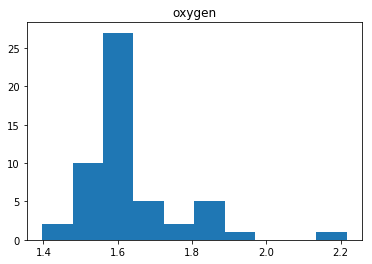

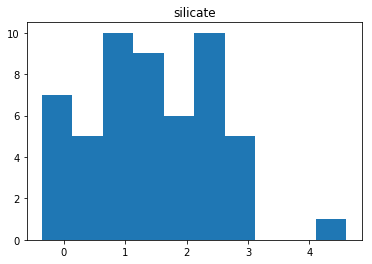

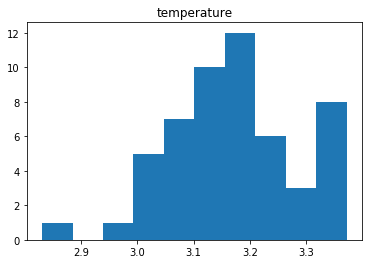

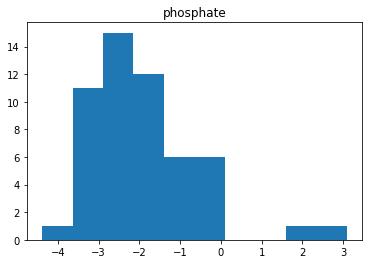

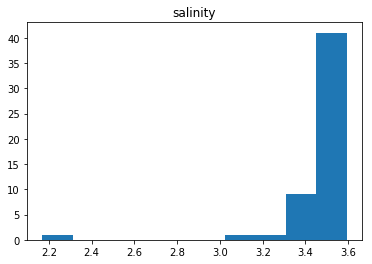

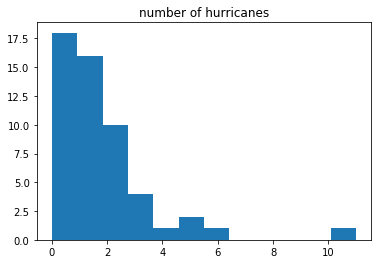

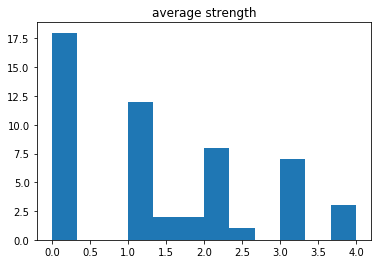

In [38]:
#histograms of features
plt.hist(np.log(wod_yr.oxygen))
plt.title('oxygen')
plt.show()

plt.hist(np.log(wod_yr.silicate))
plt.title('silicate')
plt.show()

plt.hist(np.log(wod_yr.temperature))
plt.title('temperature')
plt.show()

plt.hist(np.log(wod_yr.phosphate))
plt.title('phosphate')
plt.show()

plt.hist(np.log(wod_yr.salinity))
plt.title('salinity')
plt.show()

plt.hist(hurr_yr.name, bins=12)
plt.title('number of hurricanes')
plt.show()

plt.hist(strengths, bins=12)
plt.title('average strength')
plt.show()

None of the features seem normally distributed or linear.


Number of hurricanes seem to follow an exponential trend and Poisson's Distribution.

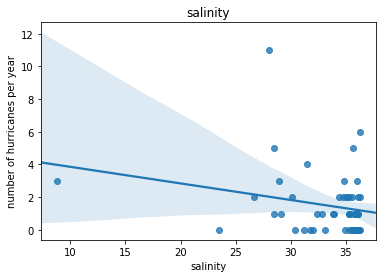

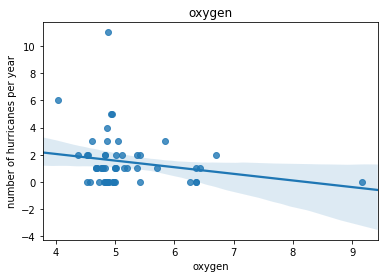

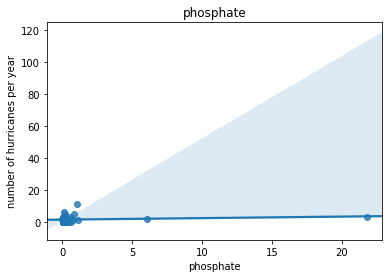

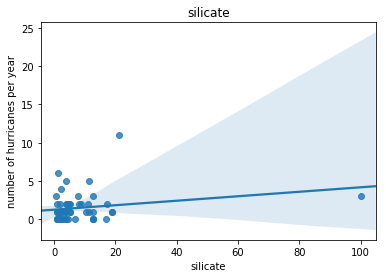

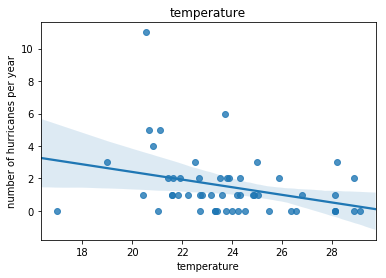

In [39]:
import seaborn as sns
#scatter plots of features vs number of hurricanes
sns.regplot(wod_yr.salinity, hurr_year.name)
plt.title('salinity')
plt.xlabel('salinity')
plt.ylabel('number of hurricanes per year')
plt.show()

sns.regplot(wod_yr.oxygen, hurr_year.name)
plt.title('oxygen')
plt.xlabel('oxygen')
plt.ylabel('number of hurricanes per year')
plt.show()

sns.regplot(wod_yr.phosphate, hurr_year.name)
plt.title('phosphate')
plt.xlabel('phosphate')
plt.ylabel('number of hurricanes per year')
plt.show()

sns.regplot(wod_yr.silicate, hurr_year.name)
plt.title('silicate')
plt.xlabel('silicate')
plt.ylabel('number of hurricanes per year')
plt.show()

sns.regplot(wod_yr.temperature, hurr_year.name)
plt.title('temperature')
plt.xlabel('temperature')
plt.ylabel('number of hurricanes per year')
plt.show()

The only feature that seems helpful is temperature as shown previously in the statistical analysis portion.